# Determining the Ising model numerically
For a good review of what this is all about, see [Inverse statistical problems: from the inverse Ising problem to data science](https://arxiv.org/abs/1702.01522). We want to solve for the variables $\boldsymbol{h}\in\mathbb{R}^{N}$ and $\boldsymbol{J}\in\mathbb{R}^{N\times(N-1)/2}$ such that our Ising model reproduces observed averages $\langle \sigma_i \rangle^D$ and correlations $\langle \sigma_i \sigma_j \rangle ^D$. We start by taking a naïve approach, using gradient ascent on the log-likelihood function:
$$
\begin{aligned}
L_{D}(\boldsymbol{h}, \boldsymbol{J}) &=\frac{1}{M} \ln p(\mathrm{D} \mid \boldsymbol{J}, \boldsymbol{h}) \\
&=\sum_{i<j} J_{i j}\left\langle\sigma_{i} \sigma_{j}\right\rangle^{D}+\sum_{i} h_{i}\left\langle\sigma_{i}\right\rangle^{D}-\ln Z(\boldsymbol{h}, \boldsymbol{J})
\end{aligned}
$$
The partial derivatives of the log-likelihood function are:
$$
\begin{aligned}
\frac{\partial L_{D}}{\partial h_i} =& \langle \sigma_i \rangle^D - \langle \sigma_i \rangle \\
\frac{\partial L_{D}}{\partial J_{ij}} =& \langle \sigma_i \sigma_j  \rangle^D - \langle \sigma_i \sigma_j \rangle
\end{aligned}
$$
and the gradient ascent update rule is:
$$
\begin{aligned}
h_i^{(t+1)} =& h_i^{(t)} + \lambda \frac{\partial L_{D}}{\partial h_i} \\
J_{ij}^{(t+1)} =& J_{ij}^{(t)} + \lambda \frac{\partial L_{D}}{\partial J_{ij}} 
\end{aligned}
$$
where $\lambda$ is the learning rate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Ising:
    """
    Represents an Ising model.
    Variables:
        N - no. spins
        av_s - vector of expectations for each spin
        av_ss - matrix of pairwise correlations
        lr - learning rate
        spin_vals - the values each spin takes on, typically [0,1] or [-1,1]
        states - matrix of all possible states
        h - vector of the local magnetic fields 
        J - matrix of the pairwise couplings 
        Z - the current value of the partition function
    """
    def __init__(self, N, avgs, corrs, lr=0.1, spin_vals=[0,1]):
        # set user input
        self.N = N
        self.avgs = avgs
        self.corrs = corrs
        self.lr = lr
        self.spin_vals = spin_vals
        # determine all states
        self.states = np.array([self.to_binary(n) for n in range(2**N)]) 
        # randomly initialise h and J
        self.h = np.random.random_sample((N))
        self.J = np.triu( np.random.random_sample((N,N)), 1)
        # work out the partition function Z
        self.Z = self.calc_Z()
    
    # Methods for calculating probabilities and expectations
    def expectation(self, f, ind, p):
        """
        Returns the sum over all states of the function f, weighted by p. 
        Args:
            f - a function of a subset of the spins
            ind - indices of the spins which are involved in f
            p - a function of the state, for instance the probability p of observing the state
        """
        exp = 0
        for s in self.states:
            exp += f( [s[i] for i in ind] ) * p(s)
        
        return exp

    def averages(self):
        """
        Returns a vector of the predicted expected values
        """
        averages = np.zeros(self.N)
        for i in range(self.N):
            averages[i] = self.expectation(lambda s: s[0], [i], self.p)
        return averages
    
    def correlations(self):
        """
        Returns a matrix of the predicted correlations values.
        We also predict the auto-correlations, though this model is not trained on them.
        """
        correlations = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(i,self.N):
                correlations[i,j] = self.expectation(lambda s: s[0]*s[1], [i,j], self.p)
        return correlations

    def p(self, s):
        """
        Returns the normalized probability of the state s given the model parameters 
        Args:
            s - np.array of the state, e.g. np.array([0,0,1]), here the third neuron fires
        """
        return np.exp(-self.H(s)) / self.Z

    def p_unnormalized(self, s):
        """
        Returns the unnormalized probability (not divided Z) of the state s given the model parameters 
        Args:
            s - np.array of the state
        """
        return np.exp(-self.H(s))

    def H(self, s):
        """
        Return the hamiltonian H(s) of the state s
        Args:
            s - np.array of the state
        """
        return -self.h.dot(s) - s@self.J@s 
            
    def calc_Z(self):
        """ 
        Calculates the partition function Z based on the current h and J.
        """
        # (the lambda function just returns 1 since this is just a sum of p over all states) 
        Z = self.expectation(lambda args: 1, [], self.p_unnormalized) 
        return Z 
    
    def to_binary(self, n):
        """
        Returns a binary rep of the int n as an array of size N, e.g. Assuming N = 5, 3 -> np.array([0,0,0,1,1]) 
        """
        b = np.zeros(self.N)
        for i in range(self.N):
            if n % 2 == 1: b[self.N-1-i]=1 # index N-1-i otherwise numbers are reversed
            n//=2
            if n==0: break
        return b

    # Methods for gradient ascent
    def gradient_ascent(self):
        """
        Performs gradient ascent on the log-likelihood and updates h and J
        """
        steps = 100
        for n in range(steps): #update this condition to check accuracy
            # work out corrections to h
            h_new = self.h
            for i in range(self.N):
                dLdhi = self.avgs[i] - self.expectation( lambda s: s[0], [i], self.p )
                h_new[i] += self.lr * dLdhi 

            # work out corrections to J
            J_new = self.J
            for i in range(self.N-1):
                for j in range(i+1,self.N):
                    dLdJij = self.corrs[i,j] - self.expectation( lambda s: s[0]*s[1], [i,j], self.p )
                    J_new[i,j] += self.lr * dLdJij 

            # perform the update
            self.h = h_new
            self.J = J_new
            self.Z = self.calc_Z()
    

In [35]:
for i in range(3):
    for j in range(i+1,4):
        print(i,j,end=", ")
    print()

0 1, 0 2, 0 3, 
1 2, 1 3, 
2 3, 


## Create an Ising model
We define all averages to be 0.5, and all pairwise correlations to be 0.2. Since we use the convention $\sigma \in \{0,1\}$, the auto-correlations should be 0.5 as well.

In [15]:
N = 7
avgs = 0.5*np.ones(N) # prob of every neuron firing in a window is 0.5
corrs = 0.2*np.triu(np.ones((N,N)),1) # prob of 2 neurons firing in the same window is 0.2 
print(avgs,corrs, sep="\n")

[0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[[0.  0.2 0.2 0.2 0.2 0.2 0.2]
 [0.  0.  0.2 0.2 0.2 0.2 0.2]
 [0.  0.  0.  0.2 0.2 0.2 0.2]
 [0.  0.  0.  0.  0.2 0.2 0.2]
 [0.  0.  0.  0.  0.  0.2 0.2]
 [0.  0.  0.  0.  0.  0.  0.2]
 [0.  0.  0.  0.  0.  0.  0. ]]


In [16]:
# create the model
ising = Ising(N, avgs, corrs, lr=0.5)

### Train the model using gradient ascent
Currently, calling `gradient_ascent` performs 100 steps of gradient ascent on the ising model. 

In [17]:
import time

In [18]:
start = time.time()
ising.gradient_ascent() # 100 steps 
stop = time.time()
print(stop-start)

13.759306907653809


### Compare predicted expectations and correlations to the actual ones

In [19]:
pred_avgs = ising.averages()
pred_corrs = ising.correlations()
print("Predicted averages:", pred_avgs, "Predicted correlations:", pred_corrs,sep="\n")

Predicted averages:
[0.47377505 0.47120583 0.46801606 0.4664079  0.4648241  0.46081373
 0.46151122]
Predicted correlations:
[[0.47377505 0.19937899 0.20039231 0.19889564 0.20040438 0.19997161
  0.1987776 ]
 [0.         0.47120583 0.20057219 0.19946738 0.20086496 0.19975157
  0.20111312]
 [0.         0.         0.46801606 0.20165324 0.19937522 0.2019905
  0.20098528]
 [0.         0.         0.         0.4664079  0.20214168 0.20149857
  0.20172355]
 [0.         0.         0.         0.         0.4648241  0.20303457
  0.19980251]
 [0.         0.         0.         0.         0.         0.46081373
  0.20307895]
 [0.         0.         0.         0.         0.         0.
  0.46151122]]


In [125]:
# function to flatten the correlation matrix and get rid of everything below the diagonal
def flatten_corr(corr):
    N = len(corr)
    flat_corr = np.zeros(N*(N-1)//2)
    k = 0
    for i in range(N-1):
        for j in range(i+1,N):
            flat_corr[k] = corr[i,j]
            k+=1
    return flat_corr

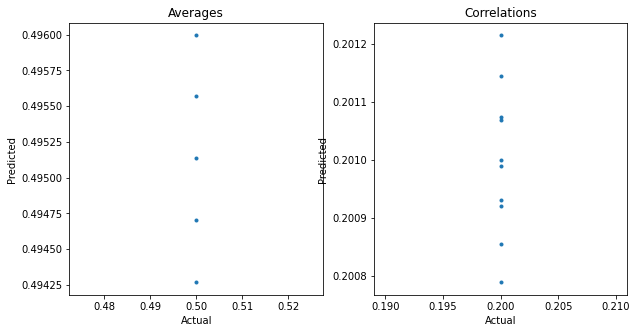

In [126]:
fig, axes = plt.subplots(1,2,figsize=(10,5)) 
axes[0].plot(avgs, pred_avgs,".")
axes[0].set_title('Averages')  
axes[0].set_xlabel('Actual')  
axes[0].set_ylabel('Predicted')  
axes[1].plot(flatten_corr(corrs),flatten_corr(pred_corrs),".")
axes[1].set_title('Correlations') 
axes[1].set_xlabel('Actual')  
axes[1].set_ylabel('Predicted')  
fig.show()